In [39]:
using Revise
using ITensors,ITensorMPS
using PastaQ
push!(LOAD_PATH,"../src/")
using RandomMeas
using ProgressBars

In [40]:
N  = 10
χ = 2^(N÷2)
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

In [41]:
NAmax = N÷2
nmax = 3
p = zeros(NAmax,nmax-1)
C3 = zeros(NAmax)
r2 = zeros(NAmax)
ITensors.disable_warn_order()
for NA in 1:NAmax
    NAB = 2*NA
    ρT,ξAB = reduce_dm(ψ,1,NAB)
    ρT = flatten(ρT)
    for i in 1:NA
        ρT  = swapind(ρT,ξAB[i],ξAB[i]')
    end
    D, U = eigen(ρT, ξAB, ξAB')
    for k in 1:nmax-1
        for s in 1:dim(D,1)
            p[NA,k] += D[s,s]^(k+1)
        end
    end
    @show NA
    C3[NA] = p[NA,1]^2/p[NA,2]
end

NA = 1
NA = 2
NA = 3
NA = 4
NA = 5


In [42]:
#Perform Randomized measurements
nu=2000
NM=100
data = zeros(Int8,(nu,NM,N))
datat = zeros(Int8,(NM,N))
u = Vector{Vector{ITensor}}()
for r in ProgressBar(1:nu, printing_delay=2)
    push!(u,get_rotations(ξ,1)) #Haar rotations in A
    get_RandomMeas!(datat,ψ,u[r])
    data[r,:,:] = datat[:,:]
end

0.0%┣                                             ┫ 0/2.0k [00:00<00:00, -0s/it]
0.8%┣▍                                            ┫ 16/2.0k [00:02<04:26, 7it/s]
2.5%┣█▏                                          ┫ 51/2.0k [00:04<02:38, 12it/s]
4.2%┣█▉                                          ┫ 83/2.0k [00:06<02:22, 13it/s]
5.5%┣██▍                                        ┫ 110/2.0k [00:08<02:21, 13it/s]
7.3%┣███▏                                       ┫ 146/2.0k [00:10<02:10, 14it/s]
9.0%┣████                                       ┫ 181/2.0k [00:12<02:04, 15it/s]
10.8%┣████▌                                     ┫ 216/2.0k [00:14<01:58, 15it/s]
12.7%┣█████▎                                    ┫ 253/2.0k [00:16<01:53, 15it/s]
14.2%┣██████                                    ┫ 284/2.0k [00:18<01:51, 15it/s]
16.0%┣██████▊                                   ┫ 320/2.0k [00:20<01:47, 16it/s]
17.8%┣███████▌                                  ┫ 356/2.0k [00:22<01:44, 16it/s]
19.6%┣████████▎             

In [43]:
C3s = zeros(NAmax)
for NA in ProgressBar(1:NAmax, printing_delay=2)
    NAB = 2*NA
    uAB = [ut[1:NAB] for ut in u]
    ξAB = ξ[1:NAB]
    #@show NA
    ρs = acquire_shadows_batch_fromdata(data[:,:,1:NAB],ξAB,uAB,nmax)
    for n in 1:nmax
        for i in 1:NA
             ρs[n] = swapind(ρs[n],ξAB[i],ξAB[i]')
        end
    end
    p = get_moments_shadows_batch(ρs, ξAB, nmax, nu)
    #@show p
    C3s[NA] = p[1]^2/p[2]
end

0.0%┣                                                ┫ 0/5 [00:00<00:00, -0s/it]
60.0%┣████████████████████████████▉                   ┫ 3/5 [00:02<00:02, 1s/it]
80.0%┣██████████████████████████████████████▍         ┫ 4/5 [00:14<00:05, 5s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:13<00:00, 48s/it]
100.0%┣██████████████████████████████████████████████┫ 5/5 [03:13<00:00, 48s/it]


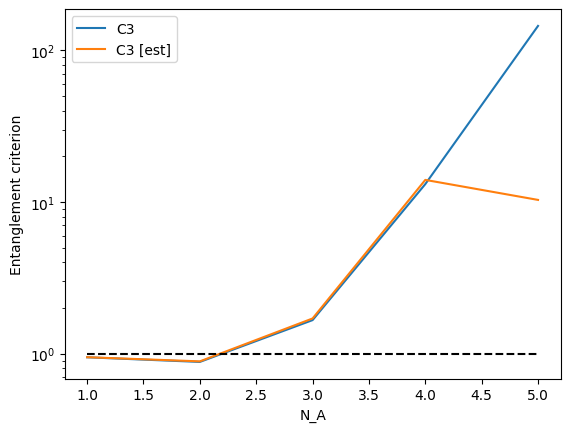

PyObject <matplotlib.legend.Legend object at 0x7f734de00910>

In [44]:
using PyPlot
PyPlot.plot(1:NAmax,C3,label="C3")
PyPlot.plot(1:NAmax,C3s,label="C3 [est]")
PyPlot.plot(1:NAmax,ones(NAmax),"--k")
xlabel("N_A")
yscale("log")
ylabel("Entanglement criterion")
legend()